<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Syntetic-tests-of-cuda-vs-numpy-vs-torch" data-toc-modified-id="Syntetic-tests-of-cuda-vs-numpy-vs-torch-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Syntetic tests of cuda vs numpy vs torch</a></span></li><li><span><a href="#Simulate-with-conv" data-toc-modified-id="Simulate-with-conv-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Simulate with conv</a></span></li></ul></div>

In [40]:
import torch as T
import numpy as np
from torch.functional import F
from tqdm import tqdm
import matplotlib.pyplot as plt
from pyrofiler import Profiler

import scripts.ising as ising

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
have_cuda = T.cuda.is_available()
# If ever run this script beter have CUDA
if not have_cuda:
    raise('CUDA not available!')
else:
    print('CUDA ok!')

CUDA ok!


## Syntetic tests of cuda vs numpy vs torch

In [3]:
#%%writefile scripts/torch_ising.py
import torch as T
import numpy as np
from itertools import product
from torch.functional import F
import scripts.ising as ising

def get_nn_mask(J, mu):
     return np.array([
         [0, J, 0]
        ,[J, mu, J]
        ,[0, J, 0]
    ])
def get_funny_mask(J, mu):
     return np.array([
         [J, J, J/2]
        ,[J, mu, J]
        ,[J/2, J, -J/2]
    ])


def get_conv_torch(mask):
    """ Get 2d torch convolution with mask """
    in_chan, out_chan = 1, 1
    shape = mask.shape
    l = T.nn.Conv2d(in_chan, out_chan, shape
                        , stride=shape
                        , padding=0
                        , bias = False
                       )
    l.weight.data = T.from_numpy(mask[np.newaxis, np.newaxis, ...])
    return l

def grid_torch(grid):
    """ Convert 2-d numpy to 4-d torch with shape 1,1,N,N """
    gpu_grid = T.from_numpy(grid[np.newaxis, np.newaxis,...]).double()
    return gpu_grid


def get_conv_nn(J, mu, device='cuda'):
    nn_mask = get_nn_mask(J, mu)
    conv = get_conv_torch(nn_mask)
    return conv.to(device)

def get_random_grid(N, device='cuda'):
    g_ = grid_torch(ising.get_random_grid(N))
    return g_.to(device)

def metrop_step(grid, conv, beta):
    rix = np.random.randint(0, high=3, size=2)
    grid = T.roll(grid, shifts=tuple(rix), dims=(2,3))
    
    dE = 2*conv(grid)[0,0]
    
    scatter_ixs = [np.arange(1, d-1, 3) for d in grid.shape[2:]]
    ixs = (0,0) + np.ix_(*scatter_ixs)
    sub = grid[ixs]
    dE = sub*dE
    
    acc_prob = T.exp(-beta*F.relu(dE))
    random = T.rand_like(acc_prob)
    sub[acc_prob > random] *= -1
    grid[ixs] = sub
    dE[acc_prob < random] *= 0
    sub[acc_prob < random] *= 0
    return grid, float(dE.sum().detach()), 2*float(sub.sum().detach())

In [59]:
from scripts import torch_ising

In [4]:
device = T.device('cpu')    

In [5]:
conv = get_conv_torch(nn_mask)
grid = grid_torch(ising.get_random_grid(50))

gr = grid.to(device)
conv = conv.to(device)
print('before', grid.mean())
dE = torch_ising(gr, conv, beta=1/2)
print('after', grid.mean())


NameError: name 'nn_mask' is not defined

## Simulate with conv

In [88]:
E = 0
N = 500
grid = grid_torch(ising.get_random_grid(N)) .to(device)

In [89]:
J = .5
mu = 0
mask = get_nn_mask(J, mu)
mask = torch_ising.get_diagonal_mask(.5, 0)
mask = torch_ising.get_funny_mask(.5, 0)
conv = get_conv_torch(mask).to(device)

beta = 1/.2;
M = float(grid.mean())
energs = [E]
mags = [M]

In [90]:
sweeps = 80
for s in tqdm(range(9*sweeps)):
    grid, dE, dM = metrop_step(grid, conv, beta=beta)
    E += dE
    energs.append(E)
    mags.append(float(grid.mean()))

100%|██████████| 720/720 [00:05<00:00, 131.69it/s]


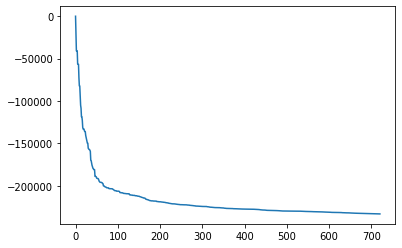

In [36]:
plt.plot(energs)

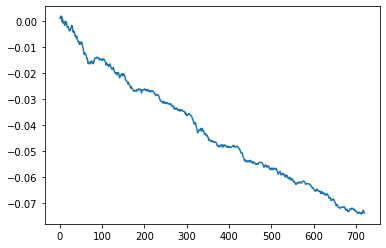

In [37]:
plt.plot(mags)

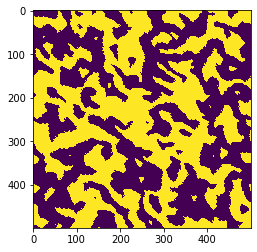

In [91]:
plt.imshow(grid[0,0].detach().numpy())

In [33]:
gr.mean()

tensor(-0.0048, dtype=torch.float64)

In [44]:
prof = Profiler()

for N in [100,500,1000, 5000]:
    r = int(N**2/9)
    rand = np.random.randint(0, N, size=(r, 2))
    grid = ising.get_random_grid(N)

    with prof.timing(f'size {N}'):
        for i in range(r):
            dE = ising.metrop_step(grid, rand[i], J, mu, 1/20, N)


size 100 : 0.0263211727142334
size 500 : 0.4037461280822754
size 1000 : 1.4705798625946045
size 5000 : 39.998366832733154


In [50]:
for N in [100, 500, 1000, 5000]:
    grid = grid_torch(ising.get_random_grid(N)) .to(device)
    mask = get_nn_mask(J, mu)
    #mask = get_funny_mask(.5, 0)
    conv = get_conv_torch(mask).to(device)
    with prof.timing(f'size {N}'):
        grid, dE, dM = metrop_step(grid, conv, beta=beta)

size 100 : 0.0008029937744140625
size 500 : 0.007186412811279297
size 1000 : 0.051480770111083984
size 5000 : 0.8673443794250488


In [35]:
th_time = r*25
print('Theoretical time for loop', th_time, 'microsec')

NameError: name 'r' is not defined

In [43]:
prof.data

{'size 100': 0.03891634941101074,
 'size 500': 0.37915539741516113,
 'size 1000': 1.492288589477539}